# Загрузка библиотек

In [ ]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
from keras import Sequential
from keras.layers import Dense, LSTM, Flatten, TimeDistributed, GlobalAveragePooling2D, Conv2D, Conv3D, MaxPooling3D, BatchNormalization, Dropout
from keras import utils as np_utils
from matplotlib import pyplot as plt
from random import  randint
from tqdm import tqdm
import os


# Подготовка выборок

In [ ]:
class DataGenerator(keras.utils.all_utils.Sequence):
    'Generates data for Keras'
    def __init__(self, part,list_IDs, batch_size, dim, n_channels,n_classes, shuffle):
        'Initialization'
        self.part = part
        self.dim = dim
        self.batch_size = batch_size

        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            #print('C:\\Users\\Admin\\anaconda3\\envs\\myTF\\vkr_uii\\vkr_npy\\' + self.part + '\\' +ID)
            #print(ID[0])
            #vkr_npy\Train\0_3.npy
            try:
              X[i,] = np.load('vkr_npy/' + self.part + '/' +ID)
            # Store class
              y[i] = int(ID[0])
            except:
              print('error = ', ID)

        return X.reshape(X.shape[0],*self.dim, 1),keras.utils.np_utils.to_categorical(y, num_classes=self.n_classes)

path = 'vkr_npy/Train/'
# чтение записей
listID_train=[]
with os.scandir(path) as listOfEntries:
    for entry in listOfEntries:
      listID_train.append(entry.name)

path = 'vkr_npy/Val/'
# чтение записей
listID_val=[]
with os.scandir(path) as listOfEntries:
    for entry in listOfEntries:
      listID_val.append(entry.name)

In [ ]:
bs = 8

In [ ]:
params = {'dim': (20,80,80),
          'n_classes': 7,
          'n_channels': 1,
          'shuffle': True}

In [ ]:
# Генераторы
training_generator = DataGenerator('Train',listID_train, bs, **params)
validation_generator = DataGenerator('Val',listID_val, bs, **params)

# Функция для построения графиков

In [ ]:
def plotTrain(hst, nameModel):
  plt.figure(1, figsize=(18, 5))
  plt.subplot(1, 2, 1)
  plt.plot(history['loss'], label='Значение ошибки на обучающем наборе')
  plt.plot(history['val_loss'], label='Значение ошибки на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Значение ошибки')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(history['accuracy'], label='Доля верных ответов на обучающем наборе')
  plt.plot(history['val_accuracy'],label='Доля верных ответов на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.title(nameModel)
  plt.legend()
  plt.show()

# Функции ля сохранения истории обучения

In [ ]:
import json, codecs

def saveHist(path, history):
    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(history, f, separators=(',', ':'), sort_keys=True, indent=4)

def loadHist(path):
    n = {}
    if os.path.exists(path):
        with codecs.open(path, 'r', encoding='utf-8') as f:
            n = json.loads(f.read())
    return n

def appendHist(h1, h2):
    if h1 == {}:
        return h2
    else:
        dest = {}
        for key, value in h1.items():
            dest[key] = value + h2[key]
        return dest

# Первая сеть с TimeDistributer

In [ ]:
model = Sequential()
model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu'),input_shape=(20, 80, 80, 1)))
model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(LSTM(1024, activation='tanh', return_sequences=False))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(7, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 78, 78, 64)    640       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 76, 76, 64)    36928     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1024)              4460544   
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 7

In [ ]:
from keras.utils.vis_utils import plot_model

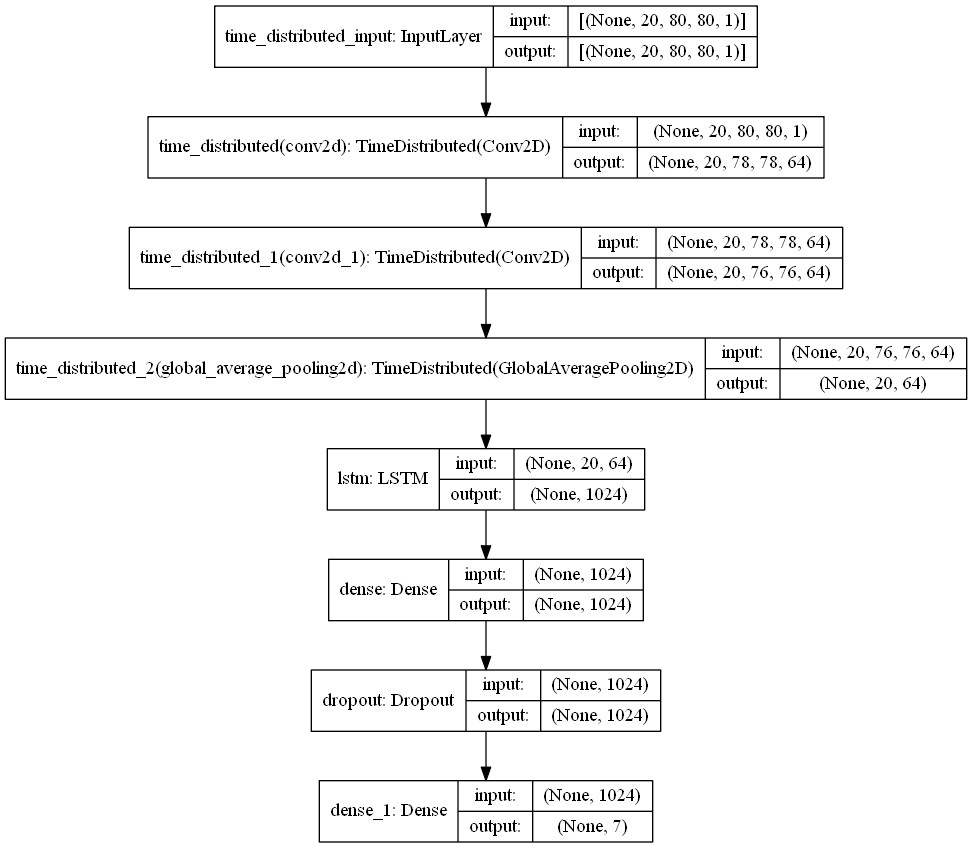

In [ ]:
plot_model(model, to_file=r'vkr\TD\model1_plot_.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.load_weights('/content/drive/MyDrive/vkr/tdv4-04-1.24.hdf5')

In [ ]:
model.compile('adamax', loss='categorical_crossentropy',metrics=["accuracy"])

In [ ]:
# коллбэк
checkpoint_filepath = r'vkr\TD\tdv2-{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
pathHistory ='vkr/TD/model1_history.json'

In [ ]:
history = loadHist(pathHistory)

In [ ]:
historyv = model.fit(training_generator,
                    epochs=50,validation_data=validation_generator,callbacks=[model_checkpoint_callback])

Epoch 1/50
751/751 [==============================] - 72s 86ms/step - loss: 1.9163 - accuracy: 0.1889 - val_loss: 1.9116 - val_accuracy: 0.1775
Epoch 2/50
751/751 [==============================] - 64s 86ms/step - loss: 1.8946 - accuracy: 0.2139 - val_loss: 1.8868 - val_accuracy: 0.1938
Epoch 3/50
751/751 [==============================] - 64s 86ms/step - loss: 1.8810 - accuracy: 0.2214 - val_loss: 1.8611 - val_accuracy: 0.2286
Epoch 4/50
751/751 [==============================] - 64s 86ms/step - loss: 1.8593 - accuracy: 0.2262 - val_loss: 1.8568 - val_accuracy: 0.2256
Epoch 5/50
751/751 [==============================] - 64s 86ms/step - loss: 1.8485 - accuracy: 0.2500 - val_loss: 1.8410 - val_accuracy: 0.2145
Epoch 6/50
751/751 [==============================] - 64s 86ms/step - loss: 1.8360 - accuracy: 0.2538 - val_loss: 1.8257 - val_accuracy: 0.2737
Epoch 7/50
751/751 [==============================] - 64s 86ms/step - loss: 1.8173 - accuracy: 0.2691 - val_loss: 1.7987 - val_accuracy:

In [ ]:
saveHist(pathHistory, historyv.history)

Получили точность 60%. На обучающей выборке точность выше не более чем нк 7%, переобучения нет. Дообучим модель еще на 50 эпохах

In [ ]:
historyv51_100 = model.fit(training_generator,
                    epochs=50,validation_data=validation_generator,callbacks=[model_checkpoint_callback])

Epoch 1/50
751/751 [==============================] - 64s 86ms/step - loss: 0.8363 - accuracy: 0.6708 - val_loss: 1.1243 - val_accuracy: 0.5888
Epoch 2/50
751/751 [==============================] - 64s 86ms/step - loss: 0.8269 - accuracy: 0.6711 - val_loss: 1.1229 - val_accuracy: 0.5762
Epoch 3/50
751/751 [==============================] - 65s 86ms/step - loss: 0.8018 - accuracy: 0.6851 - val_loss: 1.1873 - val_accuracy: 0.5688
Epoch 4/50
751/751 [==============================] - 64s 86ms/step - loss: 0.7855 - accuracy: 0.6966 - val_loss: 1.1409 - val_accuracy: 0.5777
Epoch 5/50
751/751 [==============================] - 64s 85ms/step - loss: 0.7748 - accuracy: 0.6969 - val_loss: 1.1120 - val_accuracy: 0.5962
Epoch 6/50
751/751 [==============================] - 65s 86ms/step - loss: 0.7493 - accuracy: 0.7042 - val_loss: 1.1540 - val_accuracy: 0.5865
Epoch 7/50
751/751 [==============================] - 64s 86ms/step - loss: 0.7389 - accuracy: 0.7074 - val_loss: 1.1438 - val_accuracy:

In [ ]:
history = loadHist(pathHistory)
history = appendHist(history, historyv51_100.history)
saveHist(pathHistory, history)

In [ ]:
def plotTrain(hst, nameModel):
  plt.figure(1, figsize=(18, 5))
  plt.subplot(1, 2, 1)
  plt.plot(history['loss'], label='Значение ошибки на обучающем наборе')
  plt.plot(history['val_loss'], label='Значение ошибки на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Значение ошибки')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(history['accuracy'], label='Доля верных ответов на обучающем наборе')
  plt.plot(history['val_accuracy'],label='Доля верных ответов на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.title(nameModel)
  plt.legend()
  plt.show()

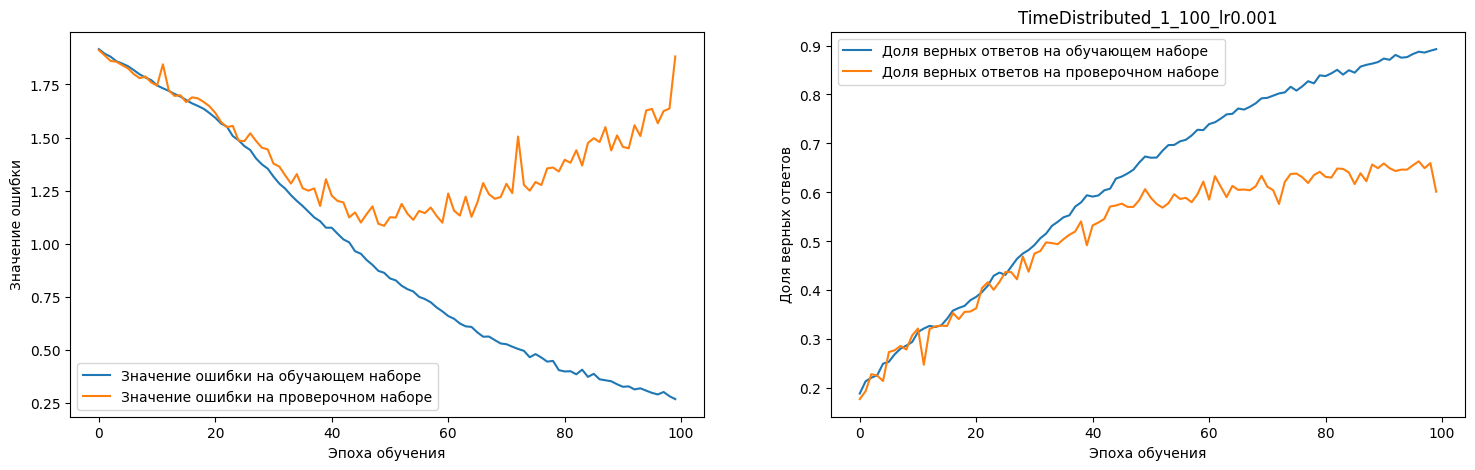

In [ ]:
plotTrain(history,'TimeDistributed_1_100_lr0.001')

Уменьшим шаг обучения, добавим расписание для экспоненциального уменьшения шага, дообучим модель еще раз.

In [ ]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

In [ ]:
checkpoint_filepath = r'vkr\TD\tdv2-lr_schedule-{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
model.load_weights('vkr/TD/tdv2-01-0.67.hdf5')
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=lr_schedule),loss='categorical_crossentropy',metrics=["accuracy"])

In [ ]:
historyv101_150_lr_schedule = model.fit(training_generator,
                    epochs=30,validation_data=validation_generator, callbacks=[model_checkpoint_callback])

Epoch 1/30
751/751 [==============================] - 67s 87ms/step - loss: 0.1584 - accuracy: 0.9409 - val_loss: 1.7066 - val_accuracy: 0.6701
Epoch 2/30
751/751 [==============================] - 65s 87ms/step - loss: 0.1464 - accuracy: 0.9457 - val_loss: 1.7558 - val_accuracy: 0.6716
Epoch 3/30
751/751 [==============================] - 65s 87ms/step - loss: 0.1378 - accuracy: 0.9489 - val_loss: 1.7759 - val_accuracy: 0.6790
Epoch 4/30
751/751 [==============================] - 65s 87ms/step - loss: 0.1340 - accuracy: 0.9494 - val_loss: 1.8320 - val_accuracy: 0.6760
Epoch 5/30
751/751 [==============================] - 65s 87ms/step - loss: 0.1307 - accuracy: 0.9519 - val_loss: 1.8718 - val_accuracy: 0.6738
Epoch 6/30
751/751 [==============================] - 65s 87ms/step - loss: 0.1253 - accuracy: 0.9554 - val_loss: 1.9066 - val_accuracy: 0.6672
Epoch 7/30
751/751 [==============================] - 65s 87ms/step - loss: 0.1242 - accuracy: 0.9507 - val_loss: 1.9547 - val_accuracy:

In [ ]:
history = loadHist(pathHistory)
history = appendHist(history, historyv101_150_lr_schedule.history)
saveHist(pathHistory, history)

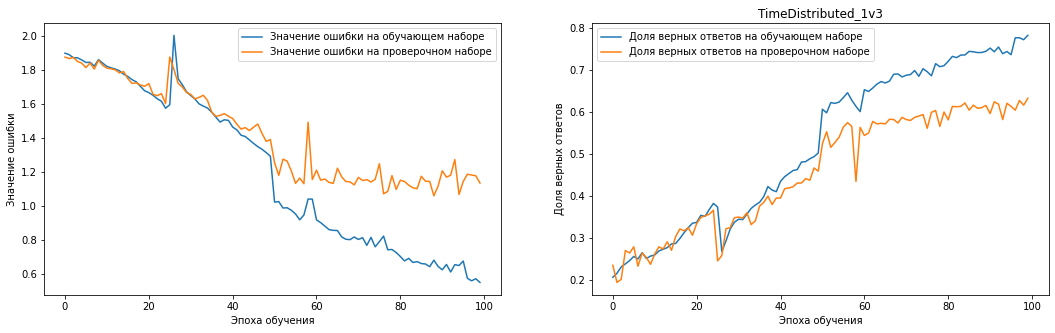

In [ ]:
plotTrain(history,'TimeDistributed_1v3')

# Вторая сеть с TimeDistributer

In [ ]:
# Вариант2 - уменьшила размеры в два раза
model2 = Sequential()
model2.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'),input_shape=(20, 80, 80, 1)))
model2.add(TimeDistributed(Conv2D(32, (3,3), activation='relu')))
model2.add(TimeDistributed(GlobalAveragePooling2D()))
model2.add(LSTM(512, activation='relu', return_sequences=False))
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(.5))
model2.add(Dense(7, activation='softmax'))

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 20, 78, 78, 32)   320       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 76, 76, 32)   9248      
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 20, 32)           0         
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 512)               1116160   
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                      

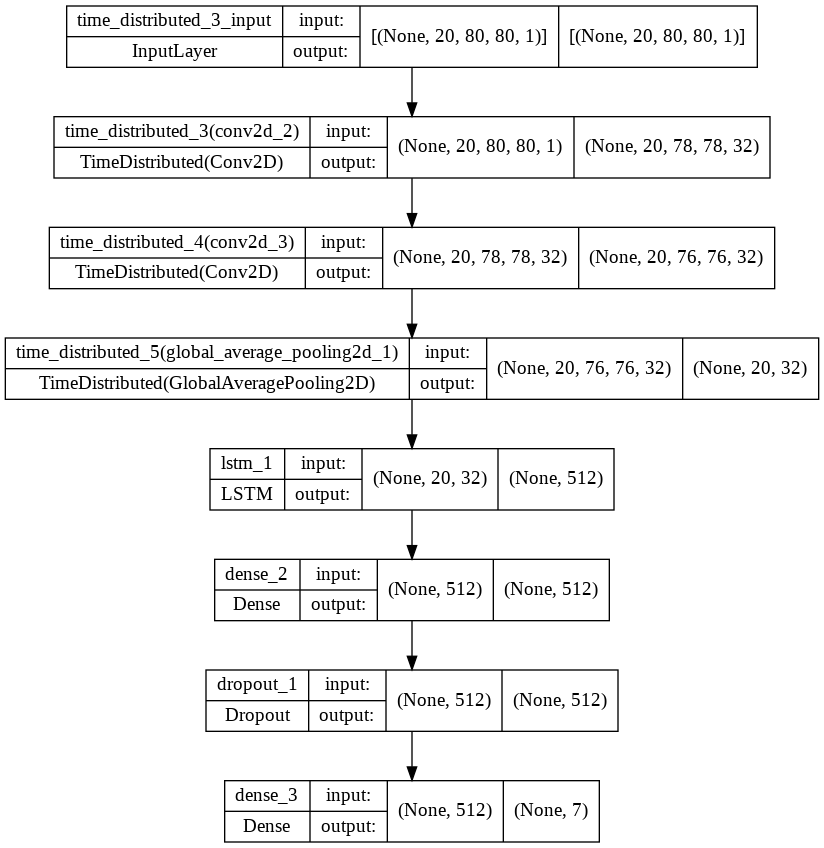

In [ ]:
plot_model(model2, to_file='/content/drive/MyDrive/vkr/model2_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model2.load_weights('/content/drive/MyDrive/vkr/td2v148-0.56.hdf5')

In [ ]:
model2.compile('adam', loss='categorical_crossentropy',metrics=["accuracy"])

In [ ]:
checkpoint_filepath2 = '/content/drive/MyDrive/vkr/td2v2-{epoch:02d}-{val_accuracy:.2f}.hdf5'
model2_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath2,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
history2v2 = model2.fit(training_generator,
                    epochs=50,validation_data=validation_generator,callbacks=[model2_checkpoint_callback])

Epoch 1/50
187/187 [==============================] - 5843s 31s/step - loss: 0.9803 - accuracy: 0.6223 - val_loss: 1.1529 - val_accuracy: 0.5469
Epoch 2/50
187/187 [==============================] - 87s 467ms/step - loss: 0.9486 - accuracy: 0.6349 - val_loss: 1.1744 - val_accuracy: 0.5506
Epoch 3/50
187/187 [==============================] - 60s 323ms/step - loss: 0.9487 - accuracy: 0.6268 - val_loss: 1.1858 - val_accuracy: 0.5588
Epoch 4/50
187/187 [==============================] - 59s 316ms/step - loss: 0.9310 - accuracy: 0.6390 - val_loss: 1.1407 - val_accuracy: 0.5625
Epoch 5/50
187/187 [==============================] - 61s 325ms/step - loss: 0.9406 - accuracy: 0.6395 - val_loss: 1.1555 - val_accuracy: 0.5640
Epoch 6/50
187/187 [==============================] - 61s 323ms/step - loss: 0.8989 - accuracy: 0.6494 - val_loss: 1.1563 - val_accuracy: 0.5543
Epoch 7/50
187/187 [==============================] - 62s 332ms/step - loss: 0.8723 - accuracy: 0.6644 - val_loss: 1.1278 - val_ac

In [ ]:
history = loadHist('/content/drive/MyDrive/vkr/model2_history.json')

In [ ]:
pathHistory2 ='/content/drive/MyDrive/vkr/model2_history.json'

In [ ]:
history = appendHist(history, history2v2.history)


In [ ]:
saveHist(pathHistory2, history)

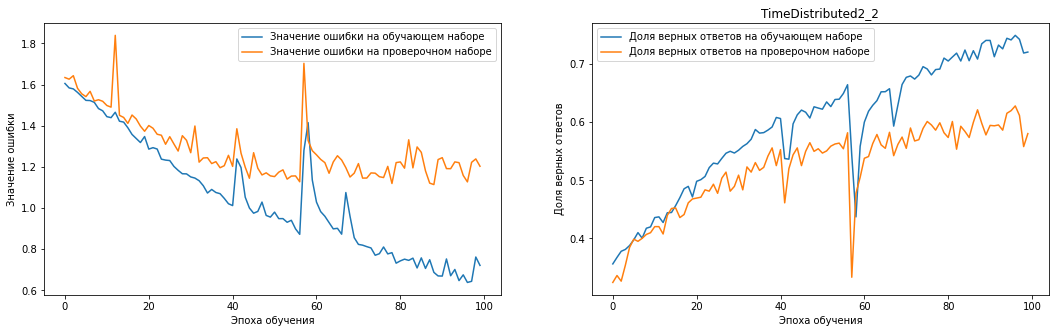

In [ ]:
plotTrain(history,'TimeDistributed2_2')

Сеть достигла 63% точности, попробуем дообучить

In [ ]:
model2.load_weights('/content/drive/MyDrive/vkr/td2v2-47-0.63.hdf5')

In [ ]:
model2.compile('adam', loss='categorical_crossentropy',metrics=["accuracy"])

In [ ]:
checkpoint_filepath2 = '/content/drive/MyDrive/vkr/td2v3-{epoch:02d}-{val_accuracy:.2f}.hdf5'
model2_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath2,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
history2v3 = model2.fit(training_generator,
                    epochs=50,validation_data=validation_generator,callbacks=[model2_checkpoint_callback])

Epoch 1/50
187/187 [==============================] - 67s 348ms/step - loss: 2.1668 - accuracy: 0.7256 - val_loss: 3.4452 - val_accuracy: 0.2753
Epoch 2/50
187/187 [==============================] - 65s 346ms/step - loss: 1.6661 - accuracy: 0.3910 - val_loss: 1.4698 - val_accuracy: 0.4293
Epoch 3/50
187/187 [==============================] - 64s 344ms/step - loss: 1.2817 - accuracy: 0.5003 - val_loss: 1.3693 - val_accuracy: 0.4978
Epoch 4/50
187/187 [==============================] - 63s 339ms/step - loss: 1.1970 - accuracy: 0.5488 - val_loss: 1.3090 - val_accuracy: 0.5149
Epoch 5/50
187/187 [==============================] - 65s 347ms/step - loss: 1.0954 - accuracy: 0.5779 - val_loss: 1.3291 - val_accuracy: 0.5156
Epoch 6/50
187/187 [==============================] - 64s 344ms/step - loss: 1.0662 - accuracy: 0.5948 - val_loss: 1.2192 - val_accuracy: 0.5461
Epoch 7/50
187/187 [==============================] - 64s 340ms/step - loss: 0.9524 - accuracy: 0.6334 - val_loss: 1.2002 - val_ac

In [ ]:
history = appendHist(history, history2v3.history)


In [ ]:
saveHist(pathHistory2, history)

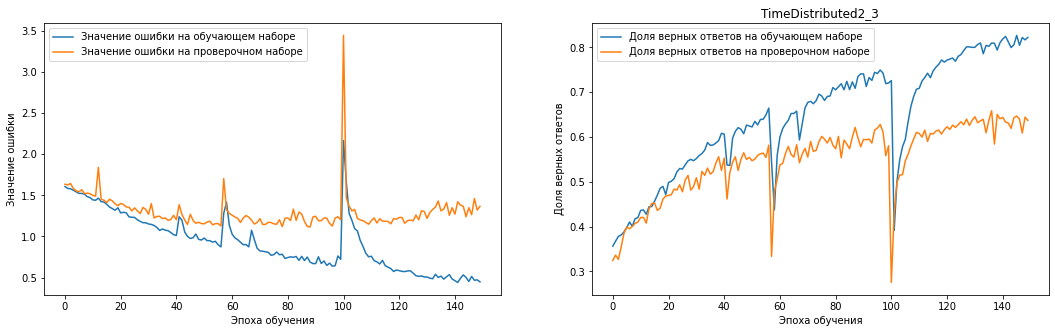

In [ ]:
plotTrain(history,'TimeDistributed2_3')

Сеть с урезанными вдвое размерами слоев также достигает 66% точности на 37 эпохе.

# Вывод

Оба из рассмотренных вариантов рекуррентных сетей показывают точность не выше 66%, Уменьшение числа параметров не повлияло значительно на точность. Думаю стоит обратиться к моделям с трехмерными свертками, они показывают лучшие результаты